In [1]:
!pip install gym[box2d]

You should consider upgrading via the 'c:\users\brome\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install -e ./ddpg-torch/pybox2d/[all]

Obtaining file:///C:/Users/brome/Documents/TA-AI/OpenAIGym/bipedal-walker/ddpg-torch/pybox2d
  Attempting uninstall: Box2D
    Found existing installation: Box2D 2.3.10
    Uninstalling Box2D-2.3.10:
      Successfully uninstalled Box2D-2.3.10
  Running setup.py develop for Box2D


You should consider upgrading via the 'c:\users\brome\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip show gym

Name: gym
Version: 0.17.2
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: c:\users\brome\anaconda3\lib\site-packages
Requires: scipy, numpy, cloudpickle, pyglet
Required-by: 


In [4]:
import gym
from gym import envs

In [5]:
env = gym.make('BipedalWalker-v3')
env.reset()
for _ in range(500):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

C:\Users\brome\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc_units=300, fc1_units=150):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):

        self.fc2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu((self.fc1(state)))
        x = F.relu((self.fc2(x)))
        return F.torch.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=300, fcs2_units=150, fca1_units=150):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fcs2 = nn.Linear(fcs1_units, fcs2_units)
        self.fca1 = nn.Linear(action_size, fca1_units)
        self.fc1 = nn.Linear(fcs2_units, 1
        self.reset_parameters()

    def reset_parameters(self):

        self.fcs2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu((self.fcs1(state)))
        xs = self.fcs2(xs)
        xa = self.fca1(action)
        x = F.relu(torch.add(xs, xa))
        return self.fc1(x)

SyntaxError: invalid syntax (<ipython-input-7-bce30fcdf977>, line 40)

In [8]:
import numpy as np
import copy
import random
from collections import namedtuple, deque

#from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = 1000000      # replay buffer size
BATCH_SIZE = 100           # minibatch size
GAMMA = 0.99               # discount factor
TAU = 0.001                # for soft update of target parameters
LR_ACTOR = 0.01          # learning rate of the actor
LR_CRITIC = 0.01          # learning rate of the critic
WEIGHT_DECAY = 0     # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.4, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
import gym
import torch
import numpy as np
#from ddpg_agent import Agent
import matplotlib.pyplot as plt

env = gym.make('BipedalWalker-v3')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=0)


def ddpg(episodes, step, pretrained, noise):

    if pretrained:
        agent.actor_local.load_state_dict(torch.load('1checkpoint_actor.pth', map_location="cpu"))
        agent.critic_local.load_state_dict(torch.load('1checkpoint_critic.pth', map_location="cpu"))
        agent.actor_target.load_state_dict(torch.load('1checkpoint_actor.pth', map_location="cpu"))
        agent.critic_target.load_state_dict(torch.load('1checkpoint_critic.pth', map_location="cpu"))

    reward_list = []

    for i in range(episodes):

        state = env.reset()
        score = 0

        for t in range(step):

            env.render()

            action = agent.act(state, noise)
            next_state, reward, done, info = env.step(action[0])
            agent.step(state, action, reward, next_state, done)
            state = next_state.squeeze()
            score += reward

            if done:
                print('Reward: {} | Episode: {}/{}'.format(score, i, episodes))
                break

        reward_list.append(score)

        if score >= 270:
            print('Task Solved')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
            torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')
            break

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
    torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')

    print('Training saved')
    return reward_list


scores = ddpg(episodes=300, step=2000, pretrained=0, noise=0)
env.close()

Reward: -97.33222532617425 | Episode: 0/300
Reward: -106.41628692260757 | Episode: 1/300
Reward: -103.32014813000399 | Episode: 2/300
Reward: -107.01485124670032 | Episode: 3/300
Reward: -103.43220382418049 | Episode: 4/300
Reward: -103.43216687922491 | Episode: 5/300
Reward: -103.4419570982245 | Episode: 6/300
Reward: -106.99444671434412 | Episode: 7/300
Reward: -103.3033473065185 | Episode: 8/300
Reward: -103.43181100834596 | Episode: 9/300
Reward: -106.98240956439575 | Episode: 10/300
Reward: -107.0100874969506 | Episode: 11/300
Reward: -103.3030295131039 | Episode: 12/300
Reward: -103.43076435076631 | Episode: 13/300
Reward: -103.4303519701163 | Episode: 14/300
Reward: -103.31299830030339 | Episode: 15/300
Reward: -104.50772182954042 | Episode: 16/300
Reward: -104.59074477252365 | Episode: 17/300
Reward: -104.80943103436567 | Episode: 18/300
Reward: -104.81003998681655 | Episode: 19/300
Reward: -104.47809816179674 | Episode: 20/300
Reward: -104.80514000327575 | Episode: 21/300
Rewa

Reward: -104.93978426483523 | Episode: 178/300
Reward: -104.82607508480861 | Episode: 179/300
Reward: -103.70007769030892 | Episode: 180/300
Reward: -104.77813459841411 | Episode: 181/300
Reward: -104.54200093516957 | Episode: 182/300
Reward: -104.54911585963643 | Episode: 183/300
Reward: -104.39494631333588 | Episode: 184/300
Reward: -104.4272851536156 | Episode: 185/300
Reward: -104.64758440528252 | Episode: 186/300
Reward: -104.4149586436109 | Episode: 187/300
Reward: -104.69258994894476 | Episode: 188/300
Reward: -104.47675625435389 | Episode: 189/300
Reward: -104.64613977931504 | Episode: 190/300
Reward: -104.58131152417263 | Episode: 191/300
Reward: -104.58912490303939 | Episode: 192/300
Reward: -104.5824569775754 | Episode: 193/300
Reward: -104.65693044651674 | Episode: 194/300
Reward: -104.47410548401625 | Episode: 195/300
Reward: -104.52356967314086 | Episode: 196/300
Reward: -104.69615232203715 | Episode: 197/300
Reward: -104.65413159111888 | Episode: 198/300
Reward: -104.756

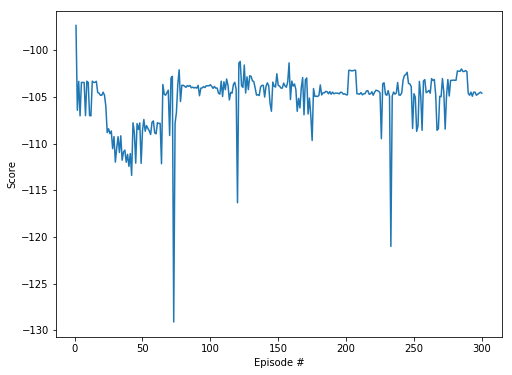

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('episodes10000v2.png')
plt.show()

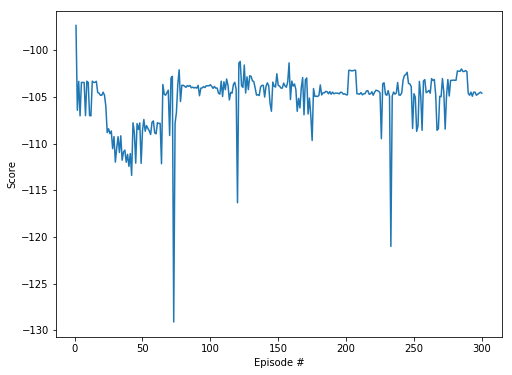

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('episodes_hardcore10000v2.png')
plt.show()

In [17]:
import numpy as np

In [14]:
np.savetxt('bipedal_scores.txt', np.array(scores))

In [15]:
scores

[-92.59647762272508,
 -95.24957763123513,
 -105.2948873630939,
 -162.58186149919504,
 -128.186327895858,
 -127.92999218980161,
 -125.83208398252788,
 -123.90061337871477,
 -124.43003618026151,
 -128.16342571461325,
 -127.78695111857292,
 -128.03455230849113,
 -127.89699644212548,
 -128.16931161667156,
 -127.93294725132114,
 -128.0583919673444,
 -126.19741550715516,
 -126.15177515262366,
 -125.94092920925965,
 -126.62365864331275,
 -126.4570017501209,
 -126.45389682216943,
 -125.82223394509096,
 -125.85036944191097,
 -125.84772064594613,
 -125.88484286738559,
 -125.63379529794865,
 -124.53523473061063,
 -124.44820045550293,
 -124.62374490223453,
 -125.03831138047141,
 -124.71276237172881,
 -124.94785510802082,
 -124.31009434345489,
 -124.36170494446158,
 -122.79009308294083,
 -123.70294848946295,
 -123.39195078245302,
 -123.13954328798565,
 -123.30372535700661,
 -123.08733391673925,
 -123.83226374616599,
 -124.14137645125948,
 -124.20641416478281,
 -117.14343866302383,
 -117.55643436950

In [ ]:
np.savetxt('bipedal_hardcore_scores.txt', np.array(scores))

In [ ]:
scores